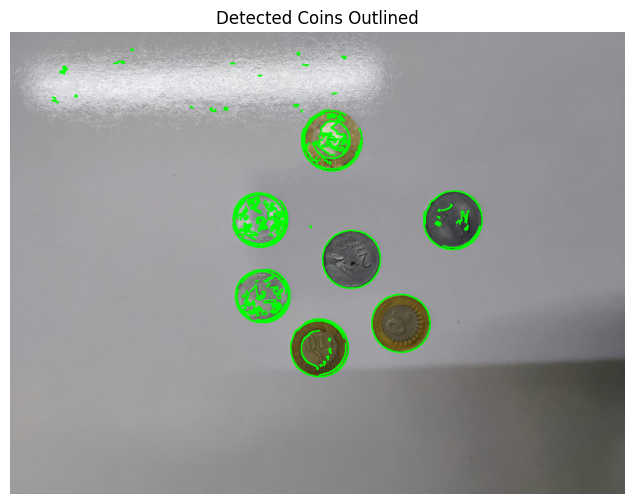

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the input image (replace 'coins.jpg' with your own image file)
img = cv2.imread('coinsimage.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, threshold1=70, threshold2=150)

# Find contours based on the edges
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image
detected_coins = img.copy()
cv2.drawContours(detected_coins, contours, -1, (0, 255, 0), 2)

# Display the result
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(detected_coins, cv2.COLOR_BGR2RGB))
plt.title("Detected Coins Outlined")
plt.axis("off")
plt.show()


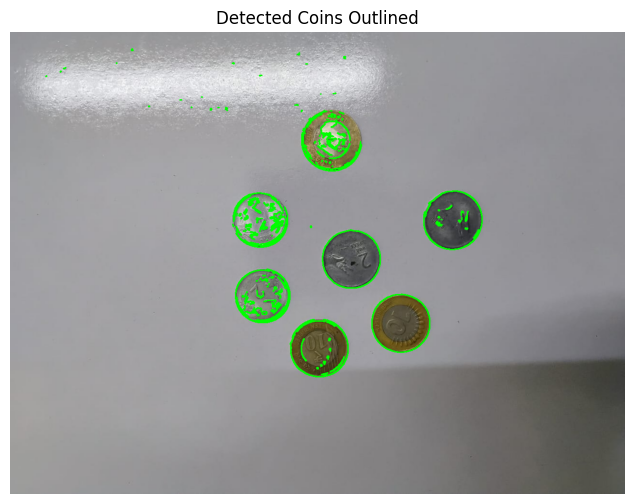

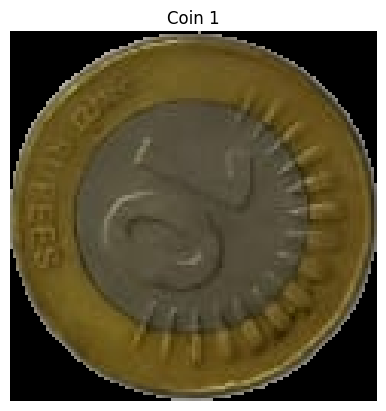

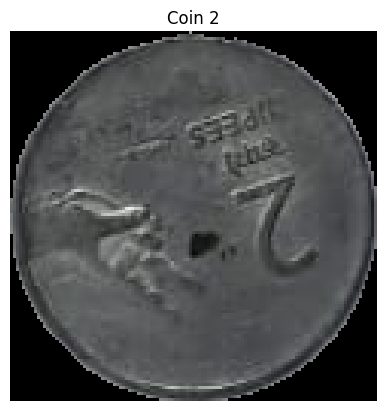

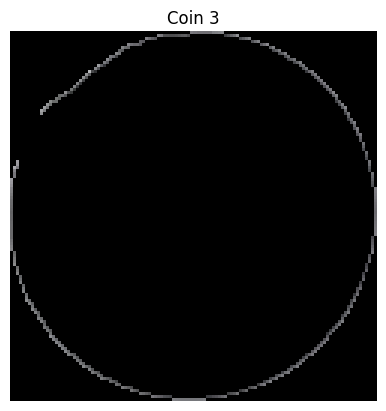

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the input image (replace 'coins.jpeg' with your image file)
img = cv2.imread('coinsimage.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)

# Apply Canny edge detection
edges = cv2.Canny(blurred, threshold1=150, threshold2=200)

# Find contours based on the edges
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on a copy of the original image for visualization
detected_coins = img.copy()
cv2.drawContours(detected_coins, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(detected_coins, cv2.COLOR_BGR2RGB))
plt.title("Detected Coins Outlined")
plt.axis("off")
plt.show()

# Segment each coin using masking
coin_images = []  # List to store each segmented coin

# Optional: filter small contours (noise) by setting a minimum area
min_area = 100  # adjust as necessary based on your image scale

for i, contour in enumerate(contours):
    if cv2.contourArea(contour) < min_area:
        continue  # skip small contours

    # Create a mask for the current contour
    mask = np.zeros(gray.shape, dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)  # fill the contour on the mask

    # Use the mask to extract the coin from the image
    coin_masked = cv2.bitwise_and(img, img, mask=mask)

    # Compute the bounding rectangle and crop the coin for a tighter view
    x, y, w, h = cv2.boundingRect(contour)
    coin = coin_masked[y:y+h, x:x+w]

    coin_images.append(coin)

# Display each segmented coin
for idx, coin in enumerate(coin_images):
    plt.figure()
    plt.imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
    plt.title(f"Coin {idx + 1}")
    plt.axis("off")
plt.show()


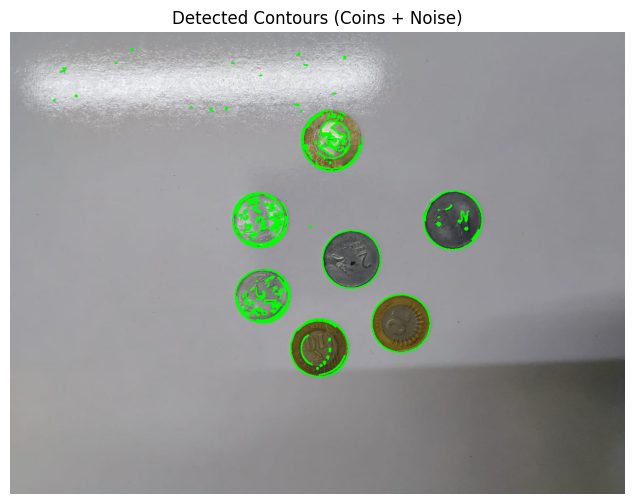

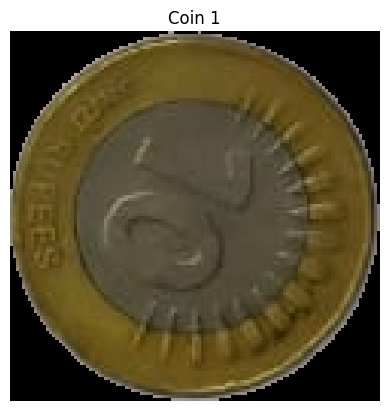

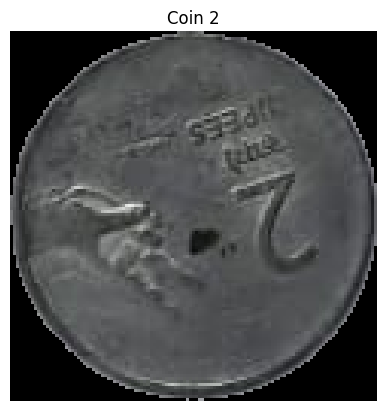

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Read and preprocess
img = cv2.imread('coinsimage.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# 2. Canny edge detection
edges = cv2.Canny(blurred, threshold1=100, threshold2=150)

# 3. Find contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 4. Draw all contours for visualization
detected_coins = img.copy()
cv2.drawContours(detected_coins, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(detected_coins, cv2.COLOR_BGR2RGB))
plt.title("Detected Contours (Coins + Noise)")
plt.axis("off")
plt.show()

# 5. Region-based filtering (area range)
min_area = 500    # Adjust as needed
max_area = 50000  # Adjust as needed

coin_images = []

for c in contours:
    area = cv2.contourArea(c)
    # Skip if the area is too small or too large
    if area < min_area or area > max_area:
        continue

    # Create a mask for this contour
    mask = np.zeros_like(gray, dtype=np.uint8)
    cv2.drawContours(mask, [c], -1, 255, -1)  # fill the contour

    # Mask the original image to extract the coin
    coin_masked = cv2.bitwise_and(img, img, mask=mask)

    # Crop to the bounding rectangle of the contour
    x, y, w, h = cv2.boundingRect(c)
    coin_cropped = coin_masked[y:y+h, x:x+w]

    coin_images.append(coin_cropped)

# 6. Display each segmented coin
for idx, coin in enumerate(coin_images):
    plt.figure()
    plt.imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
    plt.title(f"Coin {idx + 1}")
    plt.axis("off")
plt.show()


In [ ]:
def count_coins(contours):
    # Optionally, filter out small contours based on area
    min_area = 100  # adjust this threshold as needed
    coin_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    return len(coin_contours)

# Count coins based on contours from edge detection
num_coins = count_coins(contours)
print("Total number of coins detected:", num_coins)


Total number of coins detected: 7


In [ ]:
# Thresholding using Otsu's method
ret, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove noise with morphological opening
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area by dilating
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Finding sure foreground area using distance transform
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Finding unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1  # so that background is not 0 but 1
markers[unknown == 255] = 0

# Apply the watershed algorithm
markers = cv2.watershed(img, markers)
segmented = img.copy()
# Mark boundaries in red
segmented[markers == -1] = [255, 0, 0]

# Display segmented result
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
plt.title("Segmented Coins with Watershed")
plt.axis("off")
plt.show()


NameError: name 'blurred' is not defined

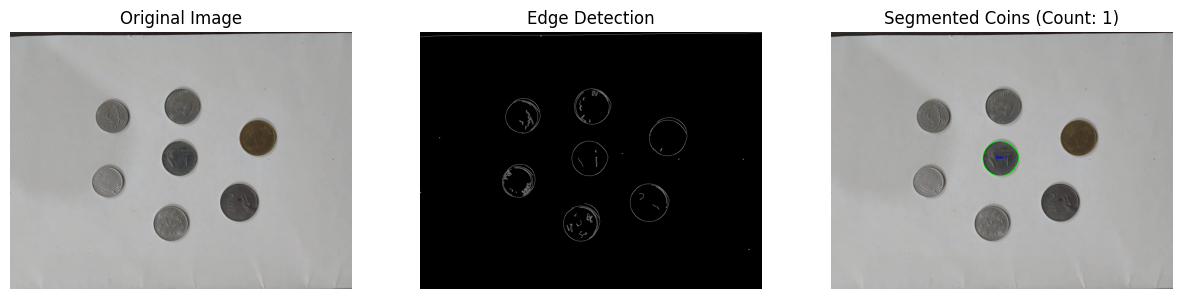


Total number of coins detected: 1


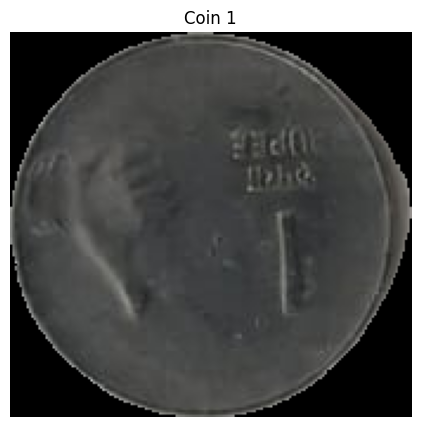

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_count_coins(image_path):
    """
    Detect, segment, and count coins in an image.

    Args:
        image_path (str): Path to the input image
    Returns:
        tuple: (original image, edge detection result, segmented image, coin count)
    """
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not read the image")

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # a. Edge Detection
    # Using Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Improve edge detection using dilation
    kernel = np.ones((3,3), np.uint8)
    dilated_edges = edges
    # b. Segmentation
    # Find contours for segmentation
    contours, _ = cv2.findContours(dilated_edges.copy(),
                                  cv2.RETR_EXTERNAL,
                                  cv2.CHAIN_APPROX_SIMPLE)

    # Create mask for segmentation
    mask = np.zeros_like(gray)

    # Filter contours based on area to remove noise
    min_coin_area = 1000  # Adjust based on your image size
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_coin_area]

    # Draw contours and create segmentation mask
    segmented_image = image.copy()
    for i, contour in enumerate(valid_contours):
        # Draw outline
        cv2.drawContours(segmented_image, [contour], -1, (0, 255, 0), 2)

        # Fill mask for this coin
        cv2.drawContours(mask, [contour], -1, (255), -1)

        # Add coin number label
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.putText(segmented_image, f"Coin {i+1}", (cX-20, cY),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # c. Count coins
    coin_count = len(valid_contours)

    # Create visualization figure
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(dilated_edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Segmented Coins (Count: {coin_count})')
    plt.axis('off')

    return image, dilated_edges, segmented_image, coin_count

def segment_individual_coins(image, contours):
    """
    Extract individual coin segments from the image.

    Args:
        image (numpy.ndarray): Input image
        contours (list): List of contours for each coin
    Returns:
        list: List of individual coin images
    """
    individual_coins = []
    for contour in contours:
        # Get bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)

        # Create mask for this coin
        mask = np.zeros_like(image[:,:,0])
        cv2.drawContours(mask, [contour], -1, (255), -1)

        # Apply mask to original image
        coin_segment = image.copy()
        coin_segment[mask == 0] = 0

        # Crop to bounding rectangle
        coin_segment = coin_segment[y:y+h, x:x+w]
        individual_coins.append(coin_segment)

    return individual_coins

# Example usage
if __name__ == "__main__":
    # Replace with your image path
    image_path = "coins.jpeg"

    try:
        # Process the image
        original, edges, segmented, count = detect_and_count_coins(image_path)

        # Display results
        plt.show()

        print(f"\nTotal number of coins detected: {count}")

        # Optional: Display individual coin segments
        # This will be useful for further analysis like denomination recognition
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000]
        individual_coins = segment_individual_coins(original, valid_contours)

        # Display individual coins
        plt.figure(figsize=(15, 5))
        for i, coin in enumerate(individual_coins):
            plt.subplot(1, len(individual_coins), i+1)
            plt.imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
            plt.title(f'Coin {i+1}')
            plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Error processing image: {str(e)}")

Error: Could not load one or both images. Check file paths.
